# GAN for MNIST digits

Will load MNIST dataset and then train a GAN to generate hand written digits. 

In [1]:
import tensorflow as tf
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# Use MNIST because tensorflow makes is super easy to use their dataset and this is an exploration notebook"
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
train = mnist.train
train_images = train.images
train_images.shape

(55000, 784)

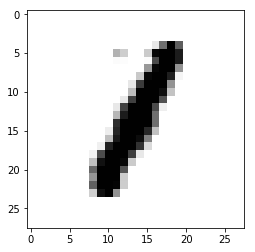

In [4]:
rand_im = train_images[randint(0,55000)].reshape([28,28])
plt.imshow(rand_im, cmap=plt.get_cmap('gray_r'))
plt.show()

# Discriminator Network (The A in GAN)

We are going to use a simple convolutional neural network as our discriminator that takes in an image (28, 28, and grayscale so 1 input for color) and output whether the input is a real image or generated. 

In [5]:
# helper functions that are useful when using tensorflow CNN
def conv2d(x, W):
    ''' creates a convoluational layer from input x and returns output layer '''
    return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
    ''' creates a pooling layer from input x and returns output layer from pooling '''
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [6]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        # First conv layer with pooling after 
        w_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [32])
        h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)
        
        # Second conv layer with pooling
        w_conv2 = tf.get_variable('d_wconv2', [5, 5, 32, 64])
        b_conv2 = tf.get_variable('d_bconv2', [64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)
        
        # Fully connected layer 
        w_fc1 = tf.get_variable('d_wfc1', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [1024], initializer=tf.constant_initializer(0))
        h_pool2_flattened = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flattened, w_fc1) + b_fc1)
        
        # second fully connected layer
        w_fc2 = tf.get_variable('d_wfc2', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))
        y_conv = (tf.matmul(h_fc1, w_fc2) + b_fc2)
    return y_conv

# Generator 
Structure of generator is similar to convolutional neural network like our discriminator, except its job is to upsample
a random vector of noise into an image, and so it uses convolutional transpose function and then batch norm and relu on the output from the tranpose. The end result is a network which takes in a noise vector and generates a 28x28x1 image which matches the MNIST dataset input data. 

In [7]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        g_dim = 64 # number of filters of first layer of generator 
        c_dim = 1 # dimension of color of output image
        s = 28 # output dimension 
        
        # get placeholders for upscale of input vector 
        s2 = 12
        s4 = 6
        s8 = 3
        s16 = 2
        
        # input 
        h0 = tf.reshape(z, [batch_size, s16, s16, 25])
        h0 = tf.nn.relu(h0)
        # h0 is [batch_size, 2, 2, 25]
        
        # first layer of deconv
        output1_shape = [batch_size, s8, s8, g_dim*4]
        w_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]],
                                  initializer=tf.constant_initializer(.1))
        h_conv1 = tf.nn.conv2d_transpose(h0, w_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        # wrap in batch norm
        h_conv1 = tf.contrib.layers.batch_norm(inputs=h_conv1, center=True, scale=True,
                                               is_training=True, scope='g_bn1')
        # wrap relu around the whole layer 
        h_conv1 = tf.nn.relu(h_conv1)
        # output shape of [batch_size, 3, 3, 256] defined in output_shape1 
        
        # second deconv layer
        output2_shape = [batch_size, s4, s4, g_dim*2]
        w_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(h_conv1.get_shape()[-1])],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]],
                                  initializer=tf.constant_initializer(.1))
        h_conv2 = tf.nn.conv2d_transpose(h_conv1, w_conv2, output_shape=output2_shape,
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        h_conv2 = tf.contrib.layers.batch_norm(inputs=h_conv2, center=True, scale=True,
                                               is_training=True, scope='g_bn2')
        h_conv2 = tf.nn.relu(h_conv2)
        # out shape [ batch_size, 6, 6, 128 ]
        
        # third deconv layer
        output3_shape = [batch_size, s2, s2, g_dim]
        w_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(h_conv2.get_shape()[-1])],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], 
                                  initializer=tf.constant_initializer(.1))
        h_conv3 = tf.nn.conv2d_transpose(h_conv2, w_conv3, output_shape=output3_shape,
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        h_conv3 = tf.contrib.layers.batch_norm(inputs=h_conv3, center=True, scale=True,
                                               is_training=True, scope='g_bn3')
        h_conv3 = tf.nn.relu(h_conv3)
        # shape [ batch_size, 12, 12, 64 ]
        
        # final deconv layer
        output4_shape = [batch_size, s, s, c_dim]
        w_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(h_conv3.get_shape()[-1])],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]],
                                  initializer=tf.constant_initializer(.1))
        h_conv4 = tf.nn.conv2d_transpose(h_conv3, w_conv4, output_shape=output4_shape,
                                         strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        h_conv4 = tf.nn.tanh(h_conv4)
    return h_conv4

In [8]:
# get a test of our generator to see if we get a valid greyscale image out of it from input vector 
sess = tf.Session()
z_dims = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dims])

sample_image = generator(z_test_placeholder, 1, z_dims)
test_z = np.random.normal(-1, 1, [1, z_dims])

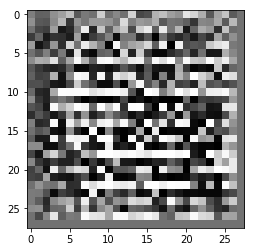

In [9]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))
my_image = temp.squeeze()
plt.imshow(my_image, cmap='gray_r')
plt.show()

# Training 

The most difficult part of GAN is probably setting up loss functions correctly. We need loss functions that fit both networks, since GANs train two networks against each other it makes sense both would have loss we need to worry about.

In [10]:
BATCH_SIZE = 12
tf.reset_default_graph() # changed batch_size so just reset graph here before trying a new session

sess = tf.Session()
x_placeholder = tf.placeholder('float', shape=[None, 28, 28, 1]) # input images
z_placeholder = tf.placeholder('float', shape=[None, z_dims]) # input for noise vectors

In [11]:
# will hold dicsriminator prediction probabilities for real MNIST images
Dx = discriminator(x_placeholder)

# Will hold images generated by generator 
Gz = generator(z_placeholder, BATCH_SIZE, z_dims)

# hold discrimator probabilities for generated images
Dg = discriminator(Gz, reuse=True)

# Loss
The goal of these two networks mean we need to maximize loss for 
- the generator and how well it can create new images that look real 
- the discriminator and how well it can distinguish between real and fake

For the generator, we want to reach a label of 1 from the discriminator, which means we calculate loss between our Dg and an expected value of 1.

For the discriminator, we want to reach correct labels, 0 for fake and 1 for MNIST digits. This means we will compute loss between Dg and 0 and Dx and 1. 

In [12]:
# generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=Dg, labels=tf.ones_like(Dg)))

# discriminator loss combines real image loss and generator image loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                             logits=Dx, labels=tf.ones_like(Dx)))
# loss for discriminator with generated images
d_loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=Dg, labels=tf.zeros_like(Dg)))

# total discriminiator loss
d_loss = d_loss_real + d_loss_gen

# Optimizers
Now we create or optimizers. Note that when we train our generator, we do not need to change weights for our discriminator, so we need to make sure we have a list of the weights we need for each 

In [13]:
tvars = tf.trainable_variables()
d_vars = [v for v in tvars if 'd_' in v.name]
g_vars = [v for v in tvars if 'g_' in v.name]

In [14]:
adam = tf.train.AdamOptimizer()
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

# Training Loop

In [15]:
sess.run(tf.global_variables_initializer())

# make a func for training progress
def _progress(count, total_count):
    sys.stdout.write('\r>> Training progress: %.1f%%' % (100*(count/total_count)))
    sys.stdout.flush()

In [16]:
TRAIN_STEPS = 150000
progress_bar_updates = 1000
steps_per_update = TRAIN_STEPS // progress_bar_updates
updates_printed = 0
for _ in range(TRAIN_STEPS):
    # get a set of noise vectors
    z_batch = np.random.normal(-1, 1, size=[BATCH_SIZE, z_dims])
    img_batch = train.next_batch(BATCH_SIZE)
    real_image_batch = np.reshape(img_batch[0], [BATCH_SIZE, 28, 28, 1])
    
    # update discriminator NN
    __, dLoss = sess.run([trainerD, d_loss], feed_dict={z_placeholder:z_batch, x_placeholder: real_image_batch})
    
    # feed generator and update it
    __, gLoss = sess.run([trainerG, g_loss], feed_dict={z_placeholder:z_batch})
    
    if _ % steps_per_update == 0:
        _progress(updates_printed, progress_bar_updates)
        updates_printed += 1
_progress(progress_bar_updates, progress_bar_updates)

>> Training progress: 100.0%

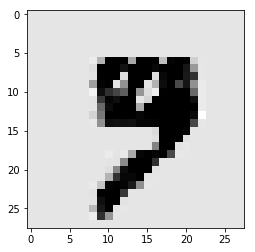

In [19]:
sampler_gen = generator(z_placeholder, 1, z_dims, reuse=True)
z_batch = np.random.normal(-1, 1, [1, z_dims])
temp = sess.run(sampler_gen, feed_dict={z_placeholder: z_batch})
img = temp.squeeze()
plt.imshow(img, cmap='gray_r')
plt.show()

Definitely an improvement from the initial generator, looking almost like a 9. For a starter GAN, worked decently after a long amount of training. 